In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# System libraries
import os
import sys
import h5py
import configparser
import json

#Standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio as rs
import rioxarray as rx

#For geometries
import shapely
from shapely import box, LineString, MultiLineString, Point, Polygon, LinearRing
from shapely.geometry.polygon import orient

#For REMA
from rasterio import plot
from rasterio.mask import mask
from rasterio.features import rasterize

#Datetime
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from dateutil.relativedelta import relativedelta
import time

#For plotting, ticking, and line collection
from matplotlib import cm 
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource, LinearSegmentedColormap
from matplotlib.lines import Line2D
import cmcrameri.cm as cmc
import contextily as cx
import earthpy.spatial as es
# for legend
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple

#Personal and application specific utilities
from utils.nsidc import download_is2
#from utils.S2 import plotS2cloudfree, add_inset, convert_time_to_string
from utils.utilities import is2dt2str
import pyTMD

#For error handling
import shutil
import traceback

#For raster
from rasterio.transform import from_origin

# not in use 
from ipyleaflet import Map, basemaps, Polyline, GeoData, LayersControl
from rasterio import warp
from rasterio.crs import CRS

In [2]:
file_1 = '/Users/ccroberts/Applications/Quantarctica3/SAR_velocity/LarsenC_velocity/mean_mosaic.201503_201505.6or12-day.1to6-pairs.tracks-all.mosaics-8.track_filt_detide.mean.y.tif'
file_ux = '/Users/ccroberts/Applications/Quantarctica3/SAR_velocity/LarsenC_velocity/mean_mosaic.202406_202408.6or12-day.1to6-pairs.tracks-all.mosaics-8.track_filt_detide.mean.x.tif'
file_uy = '/Users/ccroberts/Applications/Quantarctica3/SAR_velocity/LarsenC_velocity/mean_mosaic.202406_202408.6or12-day.1to6-pairs.tracks-all.mosaics-8.track_filt_detide.mean.y.tif'
#file_ux = 
#file_uy = '/Users/ccroberts/Applications/Quantarctica3/SAR_velocity/LarsenC_velocity/

crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'

dsux = xr.open_dataset(file_ux)
dsux.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
dsux.rio.write_crs(crs_antarctica, inplace=True)

dsuy = xr.open_dataset(file_uy)
dsuy.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
dsuy.rio.write_crs(crs_antarctica, inplace=True)

u=xr.merge([dsux.rename_vars({'band_data': 'ux'}), dsuy.rename_vars({'band_data': 'uy'})]).sel(band=1).drop_vars(['spatial_ref', 'band'])



In [3]:
shape = 'shapes/scripps_antarctic_polygons_CR.shp'

gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)
gdf = gdf[gdf.Regions=='Peninsula']

To construct a strain rate tensor without having to broadcast functions across 3500x3600 points, I use the following method:

The strain rate tensor $\dot{\varepsilon}_{ij}$ is the symmetric part of the Jacobian matrix,

$$
U_{ij} \equiv J[u_{ij}] = u_{i, j}.
$$

That is,

$$
\dot{\varepsilon}_{ij} = \frac12 \left(U_{ij} + U_{ji}\right) = \frac12 \left(\mathbf{U} + \mathbf{U}^{\top}\right).
$$

The two options are to look at (1) the principal (shear-free) strain rates or, (2) the along-flow strain rates. To achieve (1), I diagonalize the tensor with the geometry of Mohr's circle, where the center of the circle is given by $\dot{\varepsilon_{ii}}/2$, and so the radius $r$ is given by,

$$
r = \left[\frac14(\dot{\varepsilon}_{11} - \dot{\varepsilon}_{22})^2 + (\dot{\varepsilon}_{12})^2\right]^{\frac12} = 
\left[(\frac12\dot{\varepsilon}_{ij}\sigma^z_{ij})^2 + (\dot{\varepsilon}_{12})^2\right]^{\frac12},
$$

where $\mathbf{\sigma}^z$ is $\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$. Then, the principal strain rates are given by the y-intercepts of Mohr's circle defined by the above geometry,

$$
\dot{\varepsilon}^p_{ij} = c\delta_{ij} - r\sigma^z_{ij}.
$$

The angle $\theta_p$ between a given $\dot{\varepsilon}$ and the principle axis is,

$$
\theta_p = \frac12 \arctan\left(\frac{2 \varepsilon_{12}}{\dot{\varepsilon}_{11} - \dot{\varepsilon}_{22}}\right)
= \frac12 \arctan\left(\frac{2 \varepsilon_{12}}{\dot{\varepsilon}_{ij}\sigma^3_{ij}}\right).
$$

To achieve the more natural along-flow coordinate system (2), I rotate the tensor by flow angle (from x-direction defined by EPSG:3031), $\theta_u = \arctan{\frac{u_2}{u_1}}$, such that

$$
\dot{\varepsilon}^u_{ij} = R_{ki}(\theta_u)\dot{\varepsilon}_{kl}R_{lj}(\theta_u),
$$

where $R(\theta)$ is the 2D rotation matrix,


$$
\mathbf{R}(\theta) = \begin{pmatrix}
\cos\theta & -\sin\theta \\ \sin\theta & \cos\theta
\end{pmatrix}.
$$




In [14]:
x, y = u.x.values, u.y.values

u_0_0 = u.ux.differentiate(coord='x').values
u_0_1 = u.ux.differentiate(coord='y').values
u_1_0 = u.uy.differentiate(coord='x').values
u_1_1 = u.uy.differentiate(coord='y').values

# numpy arrays are denoted with capitals
# xarrays in lowercase with indices in the name

# Jacobian
U = np.array([[u_0_0, u_0_1], [u_1_0, u_1_1]])
# Pauli z matrix
pauli_3 = np.array([[1, 0], [0 , -1]])
# strain tensor
E = 0.5*(U + U.transpose(1, 0, 2, 3))
# 2D Rotation matrix and a function
R = lambda theta: np.array([[np.cos(theta*np.pi/180), -np.sin(theta*np.pi/180)], [np.sin(theta*np.pi/180), np.cos(theta*np.pi/180)]])
def rotate(T, theta): return np.einsum('ki,klmn,lj', R(theta), T, R(theta))
# Rotated strain tensor E'
E_prime = lambda theta: rotate(E, theta)

# strain tensor in x, y reference frame
e_ij = xr.DataArray(E_prime(0).transpose(3, 2, 0, 1), coords={'x': x, 'y': y}, dims=['x', 'y', 'i', 'j'])
# Principal strain rates
# mohr circle radius
r = np.sqrt((0.5*np.einsum('ij,ijmn', pauli_3, E))**2 + E[0, 1, :, :]**2)
# mohr circle center
c = 0.5*np.einsum('iimn', E)
# principle strain rates
E_p = np.einsum('imn,ij->ijmn', c - np.einsum('mn,ii->imn', r, pauli_3), np.identity(2))
E_d = E_p - (1/3)*np.einsum('iimn', E_p)
e_ij_p = xr.DataArray(E_p.transpose(3, 2, 0, 1), coords={'x': x, 'y': y}, dims=['x', 'y', 'i', 'j'])
e_ij_d = xr.DataArray(E_d.transpose(3, 2, 0, 1), coords={'x': x, 'y': y}, dims=['x', 'y', 'i', 'j'])
# angles from EPSG:3031 reference frame
theta_p = xr.DataArray(0.5*np.arctan2(E[0, 1, :, :], (np.einsum('ij,ijmn', pauli_3, E))), coords={'y': y, 'x': x})
u_mag = xr.DataArray(np.sqrt(u.ux**2 + u.uy**2), coords={'x': x, 'y': y})

# Get flow direction from velocities
theta_u = np.arctan2(u.uy, u.ux)
# Rotated train tensor DataArray
E_u = np.einsum('kimn,klmn,ljmn->ijmn', R(theta_u), E, R(theta_u))
e_ij_u = xr.DataArray(E_u.transpose(3, 2, 0, 1), coords={'x': x, 'y': y}, dims=['x', 'y', 'i', 'j'])

# set up with rio for plottting
e_ij_p.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True);
e_ij_p.rio.write_crs(crs_antarctica, inplace=True);
e_ij_u.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True);
e_ij_u.rio.write_crs(crs_antarctica, inplace=True);


TypeError: 'Axes' object is not subscriptable

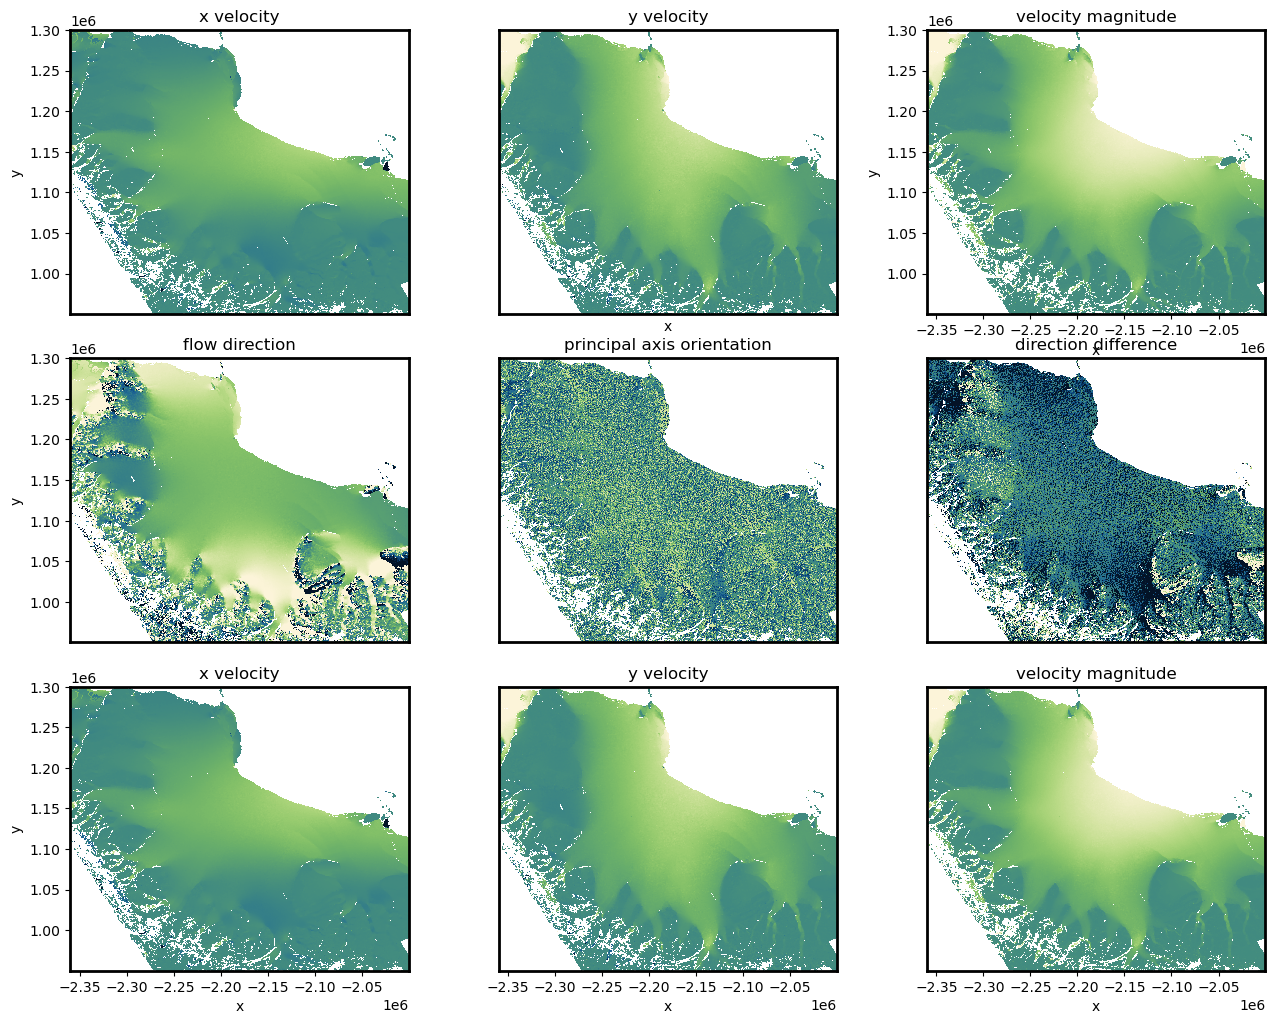

In [ ]:
vmin = -2
vmax = 2

fig, axes = plt.subplots(3, 3, figsize=[13, 10])
axes = list(np.reshape(axes, [9]))
cax=[]
for ax in axes: cax.append(ax.inset_axes([1.03, 0, 0.1, 1], transform=ax.transAxes))
fig.tight_layout()

ax = axes[0]
u.ux.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[0]})
ax.set_title('x velocity')
ax.set_xticks([])
ax.set_xlabel('')
ax = axes[1]
u.uy.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[1]})
ax.set_title('y velocity')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax = axes[2]
ax.set_xlabel('')
im1 = u_mag.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[2]})
ax.set_title('velocity magnitude')

ax = axes[3]
theta_u.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[3]})
ax.set_title('flow direction')
ax.set_xticks([])
ax.set_xlabel('')
ax = axes[4]
theta_p.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[4]})
ax.set_title('principal axis orientation')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')
ax = axes[5]
diff = theta_p - theta_u
im2 = diff.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[5]})
ax.set_title('direction difference')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')

ax = axes[6]
e_ij_u.sel(i=0, j=0).plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[6]})
ax.set_title('deviatoric strain')
ax = axes[7]
e_ij_p.sel(i=0, j=0).plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[7]})
ax.set_title('y velocity')
ax.set_yticks([])
ax.set_ylabel('')
ax = axes[8]
diff = e_ij_p.sel(i=0, j=0) - e_ij_u.sel(i=0, j=0)
im3 = u_mag.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[8]})
ax.set_title('velocity magnitude')
ax.set_yticks([])
ax.set_ylabel('')

# remove colorbars to build new ones
for c in cax: c.remove()
cb1 = fig.colorbar(im1, ax=axes[0:3], label='velocity (m day$^{-1}$)')
cb2 = fig.colorbar(im2, ax=axes[3:6], label='angle from horizontal')
cb3 = fig.colorbar(im3, ax=axes[6:9], label='strain rate (s$^{-1}$)')



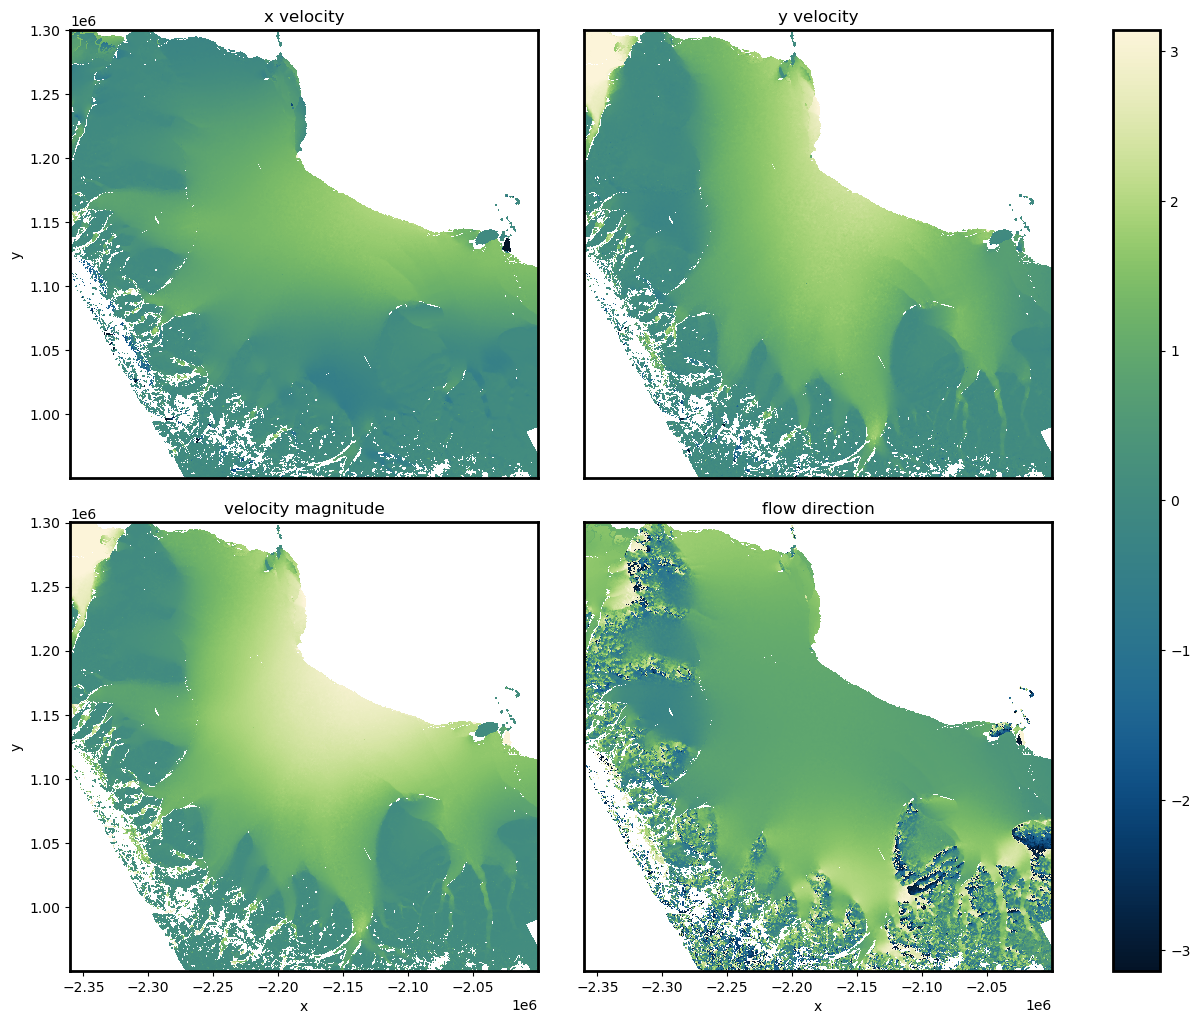

In [ ]:
vmin = -2
vmax = 2

fig, ax = plt.subplots(2, 2, figsize=[13, 10])
fig.tight_layout()
cax=[]
for a in ax.flat: cax.append(a.inset_axes([1.03, 0, 0.1, 1], transform=a.transAxes))
cax = np.reshape(cax, (2, 2))
#xr.apply_ufunc(lambda x: np.abs(x), theta_u).plot(cmap=cmc.romaO)
u.ux.plot(ax=ax[0, 0], cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[0, 0]})
ax[0, 0].set_title('x velocity')
ax[0, 0].set_xticks([])
ax[0, 0].set_xlabel('')
u.uy.plot(ax=ax[0, 1], cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[0, 1]})
ax[0, 1].set_title('y velocity')
ax[0, 1].set_yticks([])
ax[0, 1].set_ylabel('')
ax[0, 1].set_xticks([])
ax[0, 1].set_xlabel('')
u_mag.plot(ax=ax[1, 0], cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[1, 0]})
ax[1, 0].set_title('velocity magnitude')
theta_u.plot(ax=ax[1, 1], cmap=cmc.navia, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[1, 1]})
ax[1, 1].set_title('flow direction')
ax[1, 1].set_yticks([])
ax[1, 1].set_ylabel('')
for c in cax.flat: c.remove()
cb1 = fig.colorbar(im, ax=ax.ravel().tolist())
cb2 = fig.colorbar(im, ax=ax.ravel().tolist())




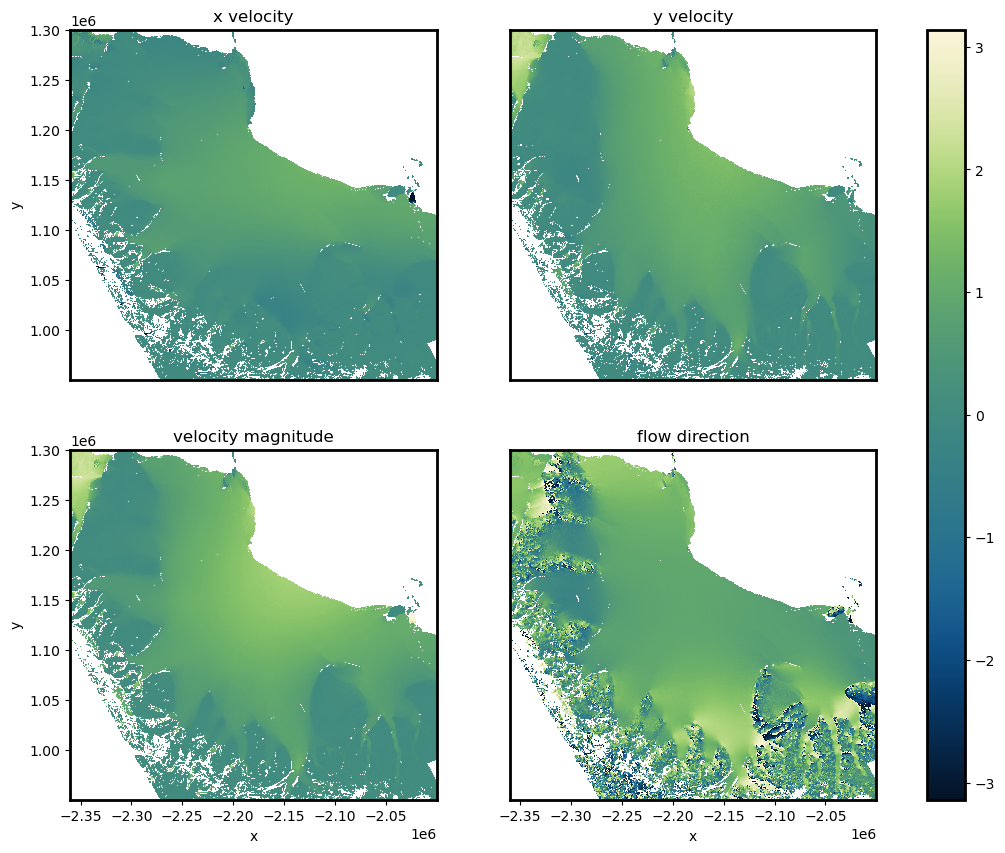

In [15]:
fig, ax = plt.subplots(2, 2, figsize=[13, 10])
cax=[]
for a in ax.flat: cax.append(a.inset_axes([1.03, 0, 0.1, 1], transform=a.transAxes))
cax = np.reshape(cax, (2, 2))
#xr.apply_ufunc(lambda x: np.abs(x), theta_u).plot(cmap=cmc.romaO)
u.ux.plot(ax=ax[0, 0], cmap=cmc.navia, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[0, 0]})
ax[0, 0].set_title('x velocity')
ax[0, 0].set_xticks([])
ax[0, 0].set_xlabel('')
u.uy.plot(ax=ax[0, 1], cmap=cmc.navia, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[0, 1]})
ax[0, 1].set_title('y velocity')
ax[0, 1].set_yticks([])
ax[0, 1].set_ylabel('')
ax[0, 1].set_xticks([])
ax[0, 1].set_xlabel('')
im = u_mag.plot(ax=ax[1, 0], cmap=cmc.navia, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[1, 0]})
ax[1, 0].set_title('velocity magnitude')
theta_u.plot(ax=ax[1, 1], cmap=cmc.navia, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[1, 1]})
ax[1, 1].set_title('flow direction')
ax[1, 1].set_yticks([])
ax[1, 1].set_ylabel('')
for c in cax.flat: c.remove()
fig.colorbar(im, ax=ax.ravel().tolist())

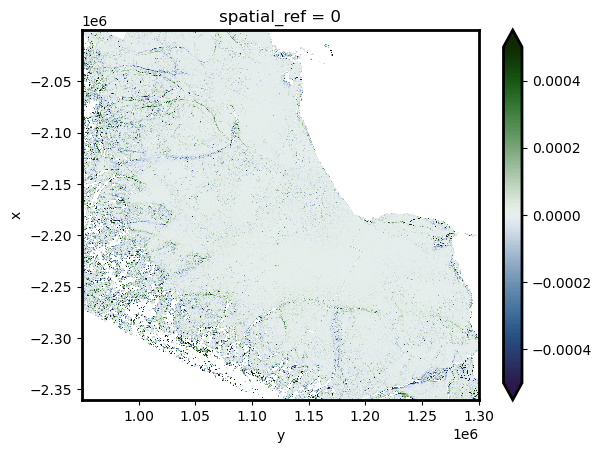

In [19]:
e_ij_prime.sel(i=0, j=1).plot(cmap=cmc.cork, vmin=-5e-4, vmax=5e-4)

In [21]:
e_ij_prime.sel(i=0, j=0)

<xarray.DataArray (x: 3600, y: 3500)> Size: 50MB
array([[-4.8050362e-05, -6.6672997e-05, -7.1698065e-05, ...,
                   nan,            nan,            nan],
       [-2.3998382e-05, -4.1663541e-05, -5.2962474e-05, ...,
                   nan,            nan,            nan],
       [ 1.0597532e-05,  1.2917294e-06, -4.6925106e-06, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
         3.1563821e-05,  4.3168871e-05, -3.7893085e-05],
       [           nan,            nan,            nan, ...,
        -2.8790723e-06,  5.2403884e-05,  4.3120177e-05],
       [           nan,            nan,            nan, ...,
        -2.5121853e-05,  4.4001295e-05,  9.0250120e-05]], dtype=float32)
Coordinates:
  * x            (x) float64 29kB -2.36e+06 -2.36e+06 ... -2e+06 -2e+06
  * y            (y) float64 28kB 1.3e+06 1.3e+06 ... 9.502e+05 9.501e+05
    spatial_ref  int64 8B 0

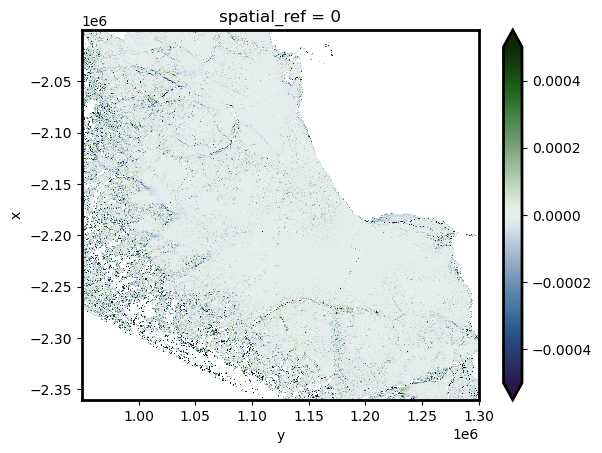

In [14]:
e_ij_prime.sel(i=0, j=0).plot(cmap=cmc.cork, vmin=-5e-4, vmax=5e-4)

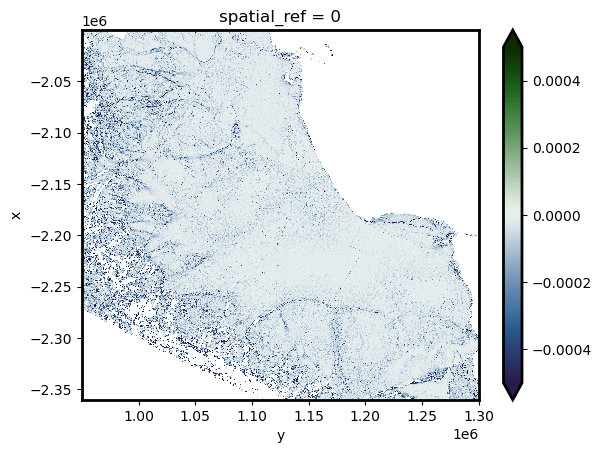

In [15]:
fig, ax = plt.subplots()
e_i.sel(i=0, j=0).plot(ax=ax, cmap=cmc.cork, vmin=-5e-4, vmax=5e-4)
#ax.set_xlim([-2.35e6, 2.35e6])
#ax.set_ylim([-2.35e6, 2.35e6])

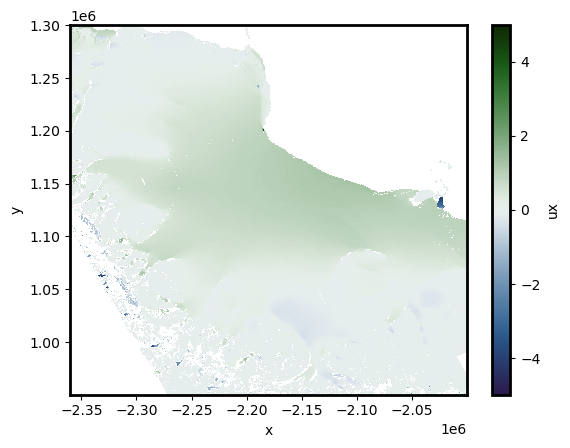

In [16]:
u.ux.plot(cmap=cmc.cork)

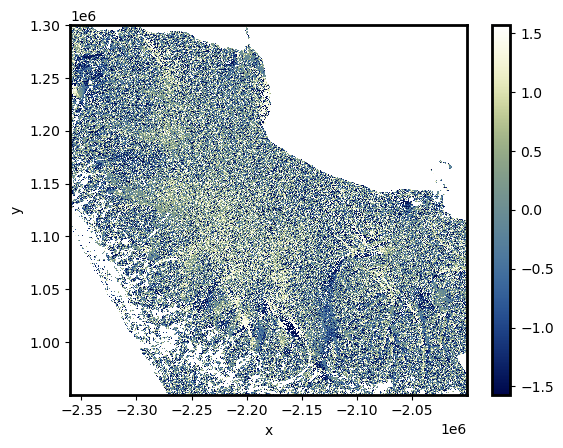

In [17]:
theta_p.plot(cmap=cmc.davos)

### Checking Eigenvalues and rotations

In [183]:
# Select a test strain tensor and rotate through 180 to try and empirically find eigenvalues

E_this = E[:, :, 1202:1203, 1202:1203]
E_this_prime = lambda theta: rotate(E_this, theta)
thetas = np.arange(0, 180, 2)
E_these = np.array([E_this_prime(theta) for theta in thetas])[:, :, :, 0, 0]

In [184]:
theta_ps = []
eigenvalues = []
rs = []
for theta in thetas:
    this = E_this_prime(theta)[:, :, 0, 0]
    #theta_ps.append(0.5*np.arctan(this[0, 1]/(2*np.max(np.einsum('ii->i', this))-this[0, 0]-this[1, 1]))*180/np.pi)
    theta_ps.append(this[0, 1]/(2*np.max(np.einsum('ii->i', this))-this[0, 0]-this[1, 1])*180/np.pi)
    eigenvalues.append(np.linalg.eigh(this, UPLO='L').eigenvalues)
    
eg = np.array(eigenvalues)

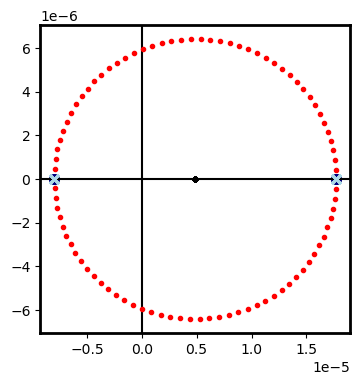

In [186]:
# Plot Mohr circle from rotation alongside eigenvalues and empirically selected eigenvalues

fig, ax = plt.subplots(figsize=[4, 4])

ax.axvline(x=0, color='black', zorder=1)
ax.axhline(y=0, color='black', zorder=2)
    
for e in E_these[:, :, :]:
    trace = np.einsum('ii', e[:, :])
    rad = np.sqrt((0.5*(e[0, 0] - e[1, 1]))**2 + (e[0, 1])**2)
    ax.scatter(trace/2, 0, color='black', marker='.')
    #ax.scatter(e[0, 0], -e[0, 1]/2, color='red', marker='.')
    ax.scatter(e[1, 1], e[0, 1]/2, color='red', marker='.')
    eg = np.linalg.eigh(e, UPLO='U').eigenvalues

    ax.scatter(eg[0], 0, color='lightblue', marker='x', zorder=50)
    ax.scatter(eg[1], 0, color='lightblue', marker='x', zorder=50)
    
    ax.scatter(trace/2+rad, 0, color='navy', marker='o')
    ax.scatter(trace/2-rad, 0, color='navy', marker='o')

In [190]:
rad_list=[]
eg_list=[]
eg_emp_list=[]
for e in E_these[:, :, :]:
    eg = np.linalg.eigh(e, UPLO='U').eigenvalues
    eg_list.append(eg)
    #rad1 = np.sqrt((e[0, 0] - 0.5*trace)**2 + (0.5*e[0, 1])**2)
    #rad2 = np.sqrt((-e[1, 1] - 0.5*trace)**2 + (0.5*e[0, 1])**2)
    #rad_list.append(rad1)
    #rad_list.append(rad2)
    rad = np.sqrt((0.5*(e[0, 0] - e[1, 1]))**2 + (e[0, 1])**2)
    trace = np.einsum('ii', e)
    rad_list.append(rad)
    eg_emp_list.append(np.array([trace/2-rad, trace/2+rad]))
    

In [ ]:
plt.figure(figsize=[5, 2])
plt.hist(theta_ps[np.array(theta_ps)<300], 2000);
plt.xlabel('angle from principal axis')
plt.xlim([-180, 180])

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 500x200 with 0 Axes>

Text(0, 0.5, 'eigenvalue')

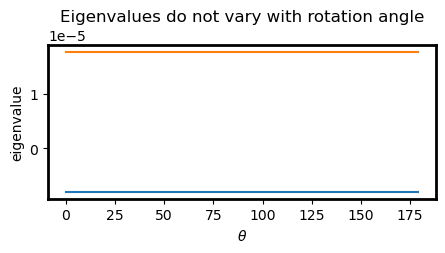

In [83]:
plt.figure(figsize=[5, 2])
plt.plot(thetas, eg[:, 0])
plt.plot(thetas, eg[:, 1])
plt.title('Eigenvalues do not vary with rotation angle')
plt.xlabel('$\\theta$')
plt.ylabel('eigenvalue')


<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_l/6jgyk_ms6jb13hn0khtb7f7m003707/T/ipykernel_43787/2881943872.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon_{11}$')
/var/folders/_l/6jgyk_ms6jb13hn0khtb7f7m003707/T/ipykernel_43787/2881943872.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\epsilon_{12}$')


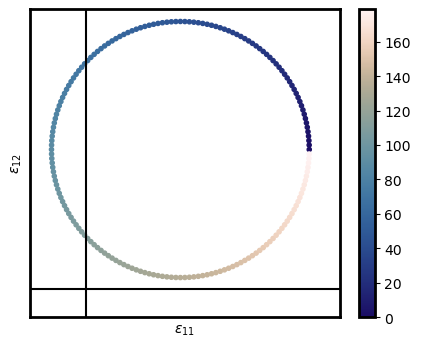

In [162]:
plt.figure(figsize=[5, 4])
plt.scatter(E_these[:, 0, 0], E_these[:, 0, 1], c=thetas, marker='.', cmap=cmc.lapaz)
plt.axvline(x=0, color='black')
plt.axhline(y=0, color='black')
plt.xlim([2e-5, -9e-5])
plt.ylim([-1e-5, 10e-5])
plt.xticks([])
plt.yticks([])
plt.xlabel('$\epsilon_{11}$')
plt.ylabel('$\epsilon_{12}$')

plt.colorbar()

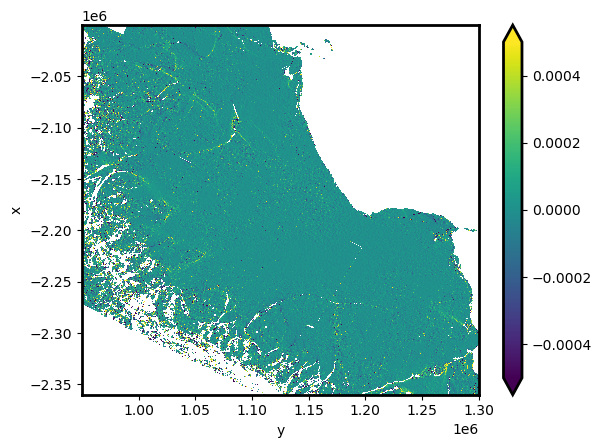

In [9]:
e_ij.isel(i=1, j=1).plot(vmin=-0.0005, vmax=0.0005)

In [349]:
# works but insanely slow
#e_ij = xr.apply_ufunc(lambda u: 0.5*(u + u.T), U_this, input_core_dims=[['i', 'j']], output_core_dims=[['i', 'j']], vectorize=True)

In [248]:
print(U_ij.isel(x=202, y=202).values)
print('+')
print(U_ij.transpose('j', 'i', 'y', 'x').isel(x=202, y=202).values)
print('=')
print((U_ij.isel(x=202, y=202)+U_ij.transpose('j', 'i', 'y', 'x').isel(x=202, y=202)).values)

[[-7.9100282e-05  2.7414560e-05]
 [ 7.2243216e-05 -1.2358427e-05]]
+
[[-7.9100282e-05  7.2243216e-05]
 [ 2.7414560e-05 -1.2358427e-05]]
=
[[-1.5820056e-04  5.4829121e-05]
 [ 1.4448643e-04 -2.4716854e-05]]


In [ ]:
print(U_ij.isel(x=202, y=202).values)
print('+')
print(U_ij.transpose('j', 'i', 'y', 'x').isel(x=202, y=202).values)
print('=')
print((U_ij.isel(x=202, y=202)+U_ij.transpose('j', 'i', 'y', 'x').isel(x=202, y=202)).values)

In [183]:
U_ij.isel(x=0, y=0)

<xarray.DataArray (i: 2, j: 2)> Size: 16B
array([[-5.6157111e-05, -1.6961098e-05],
       [ 3.4268142e-04, -1.4002562e-04]], dtype=float32)
Coordinates:
  * i        (i) int64 16B 0 1
  * j        (j) int64 16B 0 1
    y        float64 8B 1.3e+06
    x        float64 8B -2.36e+06

In [13]:
## make strain rates and rotate each element by the given theta

def get_2d_strain(u, theta=0):
    '''
    dx, dy = u.x.diff('x'), u.y.diff('y')
    duxdx = u.ux.diff('x')/dx
    duydy = u.uy.diff('y')/dy
    duxdy = u.ux.diff('y')/dx
    duydx = u.uy.diff('x')/dy
    '''
    u1_1 = u.ux.differentiate(coord='x')
    u1_2 = u.ux.differentiate(coord='y')
    u2_1 = u.uy.differentiate(coord='x')
    u2_2 = u.uy.differentiate(coord='y')
    
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    e_ij = 0.5*np.array([[2.0*u1_1, u1_2+u2_1], [u2_1+u1_2, 2.0*u2_2]])
    
    return R@e_ij@R.T
    

In [70]:
get_2d_strain(u)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

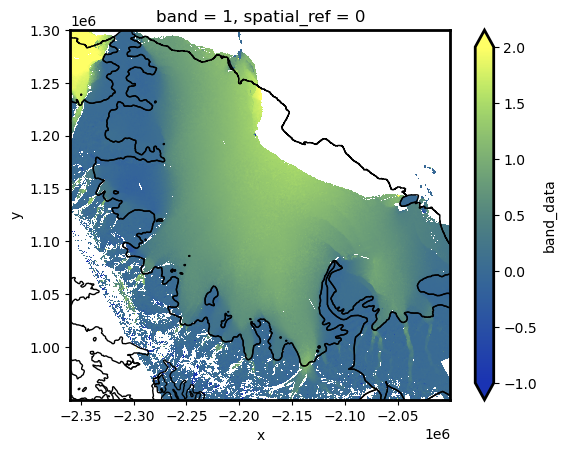

In [5]:
fig, ax = plt.subplots()

#ds_diff.band_data.plot(ax=ax, vmin=-1, vmax=1, cmap=cmc.cork)
ds2.band_data.plot(ax=ax, vmin=-1, vmax=2, cmap=cmc.imola)
gdf.plot(ax=ax, color='none', edgecolor='black')

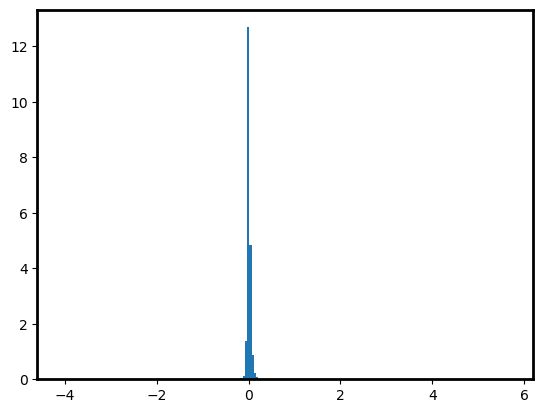

In [41]:
plt.hist(np.ndarray.flatten(ds_diff.band_data.values), 200, density=True);
#plt.ylim()